In [1]:
import pyam
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.transforms as mtransforms

from pathlib import Path
import dotenv
import os

<IPython.core.display.Javascript object>

In [2]:
dotenv.load_dotenv()

True

Step 1: Read in the necessary data for this assessment. This is basically the metadata that is crunched in the notebook `101_prepare_input_data.ipynb`

In [3]:
df = pd.read_excel(
    Path(
        '../data/101_data.xlsx'
    ),
    sheet_name='meta',
    index_col=[0,1]
)

In [4]:
delay_categories = pd.read_excel(
    Path(
        '../data/103_delay_categories.xlsx'
    ),
    index_col=[0,1]
)

Step 2: Let us pull out the necessary columns.

In [5]:
columns_of_interest = [
    'Category',
    'cumulative_gross_netzero_2100',
    'land_cdr_netzero_2100',
    'novel_cdr_netzero_2100'
]

In [6]:
df_for_analysis = df[columns_of_interest].dropna()

Step 3: Calculate the amount of land CDR for balancing gross emissions

In [7]:
df_for_analysis['land_balance'] = df_for_analysis[['cumulative_gross_netzero_2100', 'land_cdr_netzero_2100']].min(axis=1)

Step 4: The land for decline will then be the difference with the total deployed.

In [8]:
df_for_analysis['land_decline'] = df_for_analysis['land_cdr_netzero_2100'] - df_for_analysis['land_balance']

Step 5: Calculate the "remaining" gross CO2 emissions.

In [9]:
df_for_analysis['gross_after_land'] = df_for_analysis['cumulative_gross_netzero_2100'] - df_for_analysis['land_balance']

Step 6: Repeat the same procedure now for novel removals.

In [10]:
df_for_analysis['novel_balance'] = df_for_analysis[['gross_after_land', 'novel_cdr_netzero_2100']].min(axis=1)

In [11]:
df_for_analysis['novel_decline'] = df_for_analysis['novel_cdr_netzero_2100'] - df_for_analysis['novel_balance']

Step 7: Calculate the shares of the total deployment for these purposes.

In [12]:
df_for_analysis['total_balance'] = df_for_analysis['land_balance'] + df_for_analysis['novel_balance']
df_for_analysis['total_decline'] = df_for_analysis['land_decline'] + df_for_analysis['novel_decline']

In [13]:
df_for_analysis['share_balance'] = df_for_analysis['total_balance'] * 100 / (df_for_analysis['total_balance'] + df_for_analysis['total_decline'])

In [14]:
df_for_analysis['share_decline'] = 100 - df_for_analysis['share_balance']

Step 8: Statements for the shares (total)

In [15]:
(
    df_for_analysis
    .groupby('Category')[['share_balance', 'share_decline', 'total_balance', 'total_decline']]
    .describe()
    .T
    .round(1)
    .loc[pd.IndexSlice[:, ['25%', '50%', '75%']], :]
    .unstack()
)

Category          C1                   C2                   C3              
                 25%    50%    75%    25%    50%    75%    25%    50%    75%
share_balance   44.1   55.2   90.7   37.7   49.0   60.0   58.8   79.2   97.4
share_decline    9.3   44.8   55.9   40.0   51.0   62.3    2.6   20.8   41.2
total_balance  245.0  341.8  426.3  225.2  293.8  382.3  201.4  267.7  340.2
total_decline   25.7  184.4  417.8  229.8  312.2  437.0    5.1   61.9  179.2

Step 9: Concatenate the delay categories that we have crunched.

In [16]:
compiled_data = pd.concat(
    [
        delay_categories,
        df_for_analysis
    ],
    axis=1
).dropna()

In [17]:
compiled_data.groupby(['category_reductions', 'category_netzero'])['cumulative_gross_netzero_2100'].describe().round(1)

count   mean    std    min    25%  \
category_reductions category_netzero                                      
0-10                0-30               17.0  492.4  188.0  229.6  330.0   
                    30-55              35.0  407.6  127.6  139.5  337.6   
                    55-80               4.0  240.9  157.1   32.5  182.3   
10-20               0-30               33.0  406.3  163.4  175.4  280.8   
                    30-55             166.0  305.6   97.1   52.0  235.7   
                    55-80              45.0  187.4   91.9    7.4  124.7   
20-30               30-55              72.0  290.3  120.5   41.7  207.3   
                    55-80              21.0  201.4   84.5   16.7  139.4   

                                        50%    75%    max  
category_reductions category_netzero                       
0-10                0-30              498.1  564.4  929.7  
                    30-55             413.3  514.4  603.5  
                    55-80             261.5  320.1  408.3  
10-20               0-30              364.6  455.0  766.0  
                    30-55             300.1  376.3  666.3  
                    55-80             179.1  265.3  344.6  
20-30               30-55             295.3  373.2  719.0  
                    55-80             201.5  246.9  402.8

Step 9: We want to start understanding why we see these patterns post net zero. For this, we need to read in the AR6 scenario data (for the global carbon prices). This provides a decent proxy.

In [18]:
df_ar6 = pd.read_csv(
    os.environ['AR6_DATA'],
    index_col=[0,1]
)

Step 10: Filter out for the variable "carbon prices" and also for the subset of scenarios we assess in this paper.

In [19]:
df_ar6_cp = df_ar6[
    df_ar6['Variable']=='Price|Carbon'
]

In [20]:
ix = df_ar6_cp.index.intersection(df_for_analysis.index)

In [21]:
df_ar6_cp_scens = df_ar6_cp.loc[ix, :]

In [22]:
df_ar6_cp_scens_pyam = pyam.IamDataFrame(df_ar6_cp_scens.reset_index())

In [23]:
compiled_data.index.names = ['model', 'scenario']

In [24]:
df_ar6_cp_scens_pyam

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : AIM/CGE 2.0, AIM/CGE 2.1, AIM/CGE 2.2, COFFEE 1.1, ... WITCH-GLOBIOM 4.4 (24)
 * scenario : ADVANCE_2020_1.5C-2100, ADVANCE_2020_Med2C, ... SusDev_SSP2-PkBudg900 (208)
Timeseries data coordinates:
   region   : World (1)
   variable : Price|Carbon (1)
   unit     : US$2010/t CO2 (1)
   year     : 2000, 2005, 2010, 2015, 2020, 2021, 2022, 2023, ... 2100 (25)
Meta indicators:
   exclude (bool) False (1)

Step 11: Assign the metadata for what we will assess.

In [25]:
df_ar6_cp_scens_pyam.meta = compiled_data

Step 12: Read in the reanalysis data and select the CDR variables that we will assess.

In [26]:
reanalysis_data = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


In [27]:
reanalysis_data.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Population']

In [28]:
reanalysis_data_world = reanalysis_data.filter(
    region='World'
)

Step 13: Compile data for our ongoing assessment.

In [29]:
cp_cdr = pyam.concat(
    [
        df_ar6_cp_scens_pyam,
        reanalysis_data_world
    ]
)

Step 14: Explore the differences between the C1 and C2 scenarios.

matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='year', ylabel='US$2010/t CO2'>

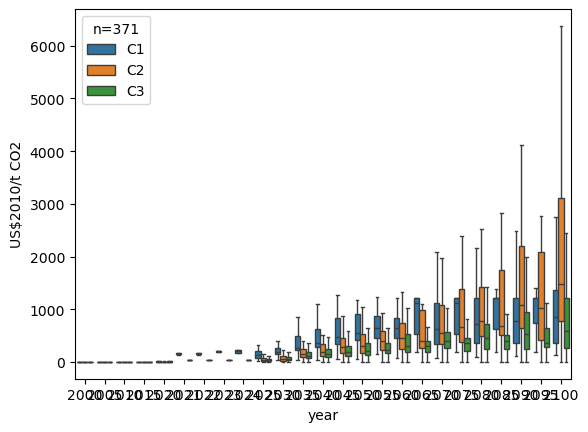

In [30]:
cp_cdr.filter(
    variable='Price|Carbon'
).plot.box(by='Category', showfliers=False)

Ok, so it looks like there is indeed some kind of tendency. Let us assign a new metadata column:
* cp(2100) - cp(netzero) / cp(netzero) - if this is positive that means the carbon price continues growing. If it is negative, then the carbon price is declining.

In [31]:
carbon_prices = (
    cp_cdr
    .filter(
        variable='Price|Carbon',
        year=range(2020, 2101)
    )
    .interpolate(
        time=range(2020,2101)
    )
    .timeseries()
)

In [32]:
diff_cp = carbon_prices.apply(
    lambda x: (x[2100] - x[cp_cdr.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']]) * 100 / x[cp_cdr.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']],
    axis=1
)

/var/folders/nz/kr7bwztj0_d9xrfz1jd4zcdh0000gp/T/ipykernel_5031/825429139.py:2: RuntimeWarning: invalid value encountered in double_scalars
  lambda x: (x[2100] - x[cp_cdr.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']]) * 100 / x[cp_cdr.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']],


In [33]:
cp_cdr.set_meta(
    meta=diff_cp,
    name='diff_cp_netzero_2100'
)

Step 15: Let us see if there are meaningful patterns

In [34]:
cp_cdr.meta['Project_study_new'] = cp_cdr.meta['Project_study'].apply(
    lambda x: 'ENGAGE' if x=='ENGAGE' else 'Other'
)

In [35]:
neg_scens = cp_cdr.meta[cp_cdr.meta['diff_cp_netzero_2100']<0]

In [36]:
cp_cdr.set_meta(
    meta='Positive',
    name='trend_cp'
)

cp_cdr.set_meta(
    meta='Negative',
    name='trend_cp',
    index=neg_scens.index
)

In [37]:
cp_cdr.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Total',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Direct',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|AFOLU|Indirect',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases',
 'AR6 Reanalysis|OSCARv3.2|Emissions|Kyoto Gases|Direct Only',
 'Price|Carbon']

Finally, we will plot the supplementary figure.

/Users/gauravganti/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
pyam.plotting - INFO: >=13 labels, not applying legend
/Users/gauravganti/anaconda3/envs/ar6_cdr_assessment/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
pyam.plotting - INFO: >=13 labels, not applying legend


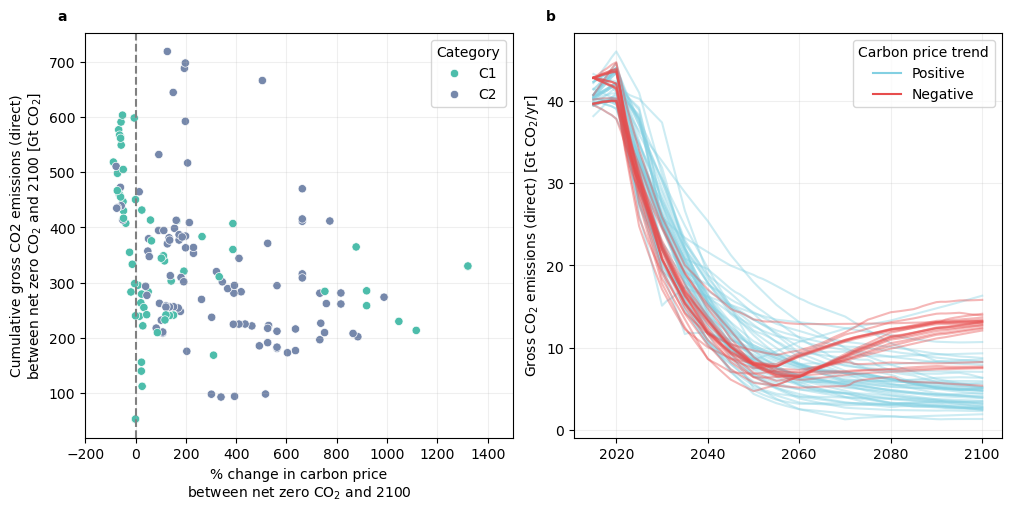

In [38]:
fig, ax = plt.subplot_mosaic(
    [
        ['a', 'b']
    ],
    figsize=(10, 5),
    constrained_layout=True
)

# Left panel - carbon price change versus residual emissions
sns.scatterplot(
    data=cp_cdr.filter(Category=['C1', 'C2']).meta,
    x='diff_cp_netzero_2100',
    y='cumulative_gross_netzero_2100',
    hue='Category',
    palette=[
        '#4dbdab',
        '#7688ab',
    ],
    ax=ax['a']
)
ax['a'].set_xlim(-200, 1500)
ax['a'].axvline(0, color='grey', linestyle='dashed')
ax['a'].set_xlabel('% change in carbon price\nbetween net zero CO$_2$ and 2100')
ax['a'].set_ylabel('Cumulative gross CO2 emissions (direct)\nbetween net zero CO$_2$ and 2100 [Gt CO$_2$]')

# Right panel - the different cp trends for the c1 scenarios
cp_colors = {
    'Positive':'#83d0e2',
    'Negative':'#e74d4d'
}

for cat in cp_colors.keys():
    cp_cdr.filter(
        Category=['C1'],
        variable=[
            'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross'
        ],
        trend_cp=cat,
        year=range(2015, 2101)
    ).plot(ax=ax['b'], color=cp_colors[cat], alpha=0.4)

legend_handles = [
    Line2D([0], [0], color='#83d0e2', label='Positive'),
    Line2D([0], [0], color='#e74d4d', label='Negative'),
] 
ax['b'].legend(handles=legend_handles, title='Carbon price trend')
ax['b'].set_title('')
ax['b'].set_xlabel('')
ax['b'].set_ylabel('Gross CO$_2$ emissions (direct) [Gt CO$_2$/yr]')

# Final annotations and labels
for lab,a in ax.items():
    a.grid(alpha=0.2)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, lab, transform=a.transAxes + trans,
             va='bottom', weight='bold')

In [39]:
fig.savefig(
    Path(
        'figures/SI_fig1.png'
    ),
    dpi=400,
    bbox_inches='tight'
)